# Library

## Python packages 

In [1]:
import pandas as pd
import numpy as np
import regex as re
import rpy2
import os
import functools as fct
from collections import Counter
import pickle 

/Users/tanya/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## R packages 

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(rlang)
library(ggplot2)
library(dplyr)
library(scales)
library(reshape2)
library(cowplot)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Set paths 

In [4]:
# Set paths 

path_to_vcfs = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/data'   # path to initial ClinVar dfs
path_to_gatk = '/Users/tanya/Documents/tools/gatk-4.5.0.0/gatk'
path_to_tables = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/tables'
path_to_plots = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/plots'
path_to_temp = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/temp'

## Load data 

In [5]:
with open(f'{path_to_temp}/cv_dict.pkl', 'rb') as file:  # load main dict
    cv_dict = pickle.load(file)
    
with open(f'{path_to_temp}/coi_clnsig.pkl', 'rb') as file:  # load coi_clnsig dict
    coi_clnsig = pickle.load(file)

In [7]:
with open(f'{path_to_temp}/cv_dict.pkl', 'rb') as file:  # load main dict
    cv_dict = pickle.load(file)

with open(f'{path_to_temp}/id_clnsig.pkl', 'rb') as file:   # load CLNSIG dict
    id_clnsig = pickle.load(file)

#with open(f'{path_to_temp}/id_revstat.pkl', 'rb') as file:   # load CLNREVSTAT dict
#    id_revstat = pickle.load(file)
    
with open(f'{path_to_temp}/id_clnsigconf.pkl', 'rb') as file:  # load CLNSIGCONF dict
    id_clnsigconf = pickle.load(file)

with open(f'{path_to_temp}/coi_clnsig.pkl', 'rb') as file:  # load coi_clnsig dict
    coi_clnsig = pickle.load(file)
    

# Dynamics of COI

## Collect total number of variants, number  and % of COI

In [8]:
coi_dynamics = {}

for vcf in cv_dict:
    coi_dynamics[vcf] = []
    
    coi_num = cv_dict[vcf][cv_dict[vcf]['CLNSIG_MASK'] == 'COI'].shape[0]
    coi_perc = (round(coi_num /cv_dict[vcf].shape[0],3))*100
    coi_dynamics[vcf].append(coi_num)
    coi_dynamics[vcf].append(coi_perc)
    coi_dynamics[vcf].append(cv_dict[vcf].shape[0])

# sort dictionary by key values
coi_dynamics = dict(sorted(coi_dynamics.items()))

#  make df from dict
coi_dynamics_df = pd.DataFrame.from_dict(coi_dynamics, orient='columns')
coi_dynamics_df = coi_dynamics_df.transpose().reset_index(names = ['cv_vcf'])
coi_dynamics_df.columns = ['cv_vcf', 'num_conflicts_of_interpretation',
                           'percent_conflicts_of_interpretation',
                           'All_variants']

# save df

coi_dynamics_df.to_csv('./temp/coi_dynamics_df.csv', sep='\t', index=False)

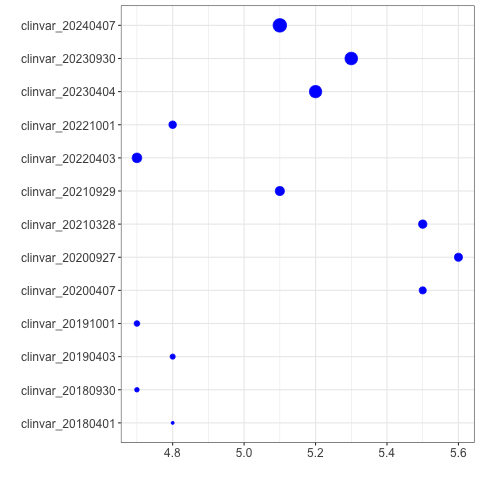

In [11]:
%%R -i coi_dynamics_df

theme_set(theme_bw())

coi_dynamics_plt <- ggplot(coi_dynamics_df,
                    aes(x=cv_vcf,
                        #y=All_variants,
                        #y=num_conflicts_of_interpretation,
                        y=percent_conflicts_of_interpretation,
                        size=num_conflicts_of_interpretation)) + 
geom_point(, color='blue') + theme(legend.position = "none", 
                                   axis.text=element_text(size=12),
                                   axis.title=element_text(size=14,face="bold")) + xlab("") +ylab("") + coord_flip()

coi_dynamics_plt

## Are there any variants that were “Conflicting” but became non-conflicting over time?  

In [12]:
def find_last_interpetation(clnsig_dict):
    """   
    For each COI variant collects last interpretation
  
  Args: 
    clnsig_dict: A dictionary where keys are variant IDs and values are sorted lists of clinical significance records.
  
  Returns:
    A pandas dataframe  where keys are variant IDs. Values are CLNSIG records in last VCF
    """
    last_interpretation = {}
    for variant_id, significance_records in clnsig_dict.items():
        last_interpretation[variant_id] = significance_records[-1]
    
    # transform to df
    last_interpretation_df = pd.DataFrame(last_interpretation.items(), columns=['varid', 'last_clnsig'])
    
    return last_interpretation_df

In [13]:
coi_last_clnsig = find_last_interpetation(coi_clnsig)
coi_last_clnsig = coi_last_clnsig.groupby('last_clnsig').size().reset_index('last_clnsig')
coi_last_clnsig.columns = ['last_CLNSIG', 'count']

coi_last_clnsig.to_csv('./temp/coi_last_clnsig.csv', sep='\t', index=False)  # save to plot in R

In addition: Warning message:
Duplicated aesthetics after name standardisation: size 


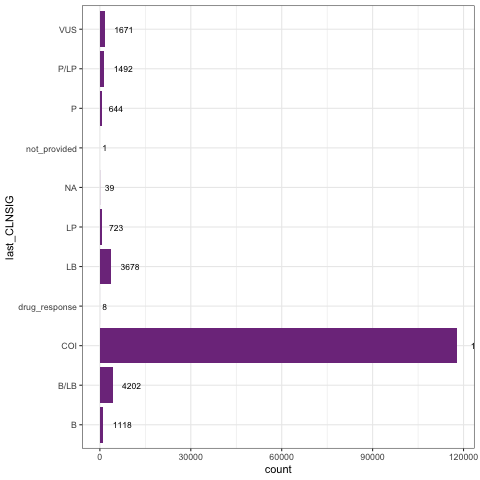

In [14]:
%%R -i coi_last_clnsig

# barplot with final classification (B/LB/VUS/P/LP) 

coi_last_clnsig_plt <- ggplot(coi_last_clnsig, aes(y=last_CLNSIG, x=count, label=count)) + geom_bar(stat='identity',
                                                                                                    fill='#7F388B')+
geom_text(size = 3, hjust = -0.5, size = 1, position = position_dodge(width = 1), inherit.aes = TRUE) 

coi_last_clnsig_plt

In [15]:
def analyze_resolved_conflicts(clnsig_dict, coi_list):
    
    """
    Analyzes variants with conflicting pathogenicity interpretations in ClinVar data.

  Args:
      clnsig_dict: A dictionary where keys are variant IDs and values are sorted lists of clinical significance records.
      conflicts_list: A list of strings representing conflicting interpretation records in INFO/CLNSIG column.

  Returns:
      A dictionary where keys are variant IDs. Values are either:
          - A set of non-conflicting classifications encountered.
          - 'conflict_up_again' if the last record is in conflicts_list.
    """
    
    coi_to_resolved = {}
    for variant_id, significance_records in clnsig_dict.items():
        coi_to_resolved[variant_id] = []
        coi_seen = False  # Flag to track conflicting interpretations
        for record in significance_records:
            if record in conflicts_list:
                coi_seen = True
            elif coi_seen and record not in coi_list:  # Resolved after conflict
                coi_to_resolved[variant_id].append(record)
                coi_seen = False

        if significance_records[-1] in coi_list:
            coi_to_resolved[variant_id].append('conflict_up_again')

    return coi_to_resolved

## How many variants became non-conflicting until the present date vs how many were conflicting - non-conflicting - conflicting?

In [16]:
for variant_id, significance_records in coi_clnsig.items():
    conflicting_seen = False 
    print(significance_records[-1])

nan
P/LP
COI
COI
VUS
COI
COI
COI
COI
COI
COI
COI
COI
COI
B/LB
COI
COI
COI
COI
COI
COI
COI
P
P
LP
COI
VUS
COI
COI
COI
COI
COI
COI
COI
COI
COI
COI
COI
LP
P
LP
drug_response
COI
COI
COI
COI
COI
COI
COI
COI
COI
COI
COI
VUS
VUS
COI
COI
B
COI
COI
B/LB
P
COI
COI
COI
COI
B/LB
COI
P/LP
COI
COI
COI
COI
P/LP
COI
COI
P/LP
COI
COI
VUS
P/LP
COI
COI
COI
COI
COI
COI
COI
COI
COI
COI
COI
B
COI
VUS
COI
COI
COI
COI
COI
COI
COI
COI
COI
COI
VUS
COI
COI
COI
VUS
COI
COI
P/LP
P/LP
COI
COI
COI
COI
COI
P
COI
COI
COI
COI
P/LP
COI
P/LP
COI
COI
COI
COI
B/LB
COI
P/LP
COI
COI
COI
B
B/LB
COI
B/LB
VUS
VUS
COI
P/LP
P
VUS
COI
P/LP
COI
COI
B
P/LP
P
P
COI
LP
COI
COI
COI
COI
P/LP
COI
COI
P/LP
COI
COI
COI
P
COI
COI
COI
B
P/LP
COI
VUS
LP
B
VUS
COI
COI
COI
COI
COI
B
COI
VUS
P
COI
P/LP
COI
P/LP
COI
COI
COI
COI
COI
COI
COI
drug_response
COI
P/LP
VUS
COI
COI
COI
B/LB
P/LP
P
P
COI
P
B/LB
COI
COI
COI
COI
B/LB
COI
COI
COI
P
P
COI
COI
COI
VUS
COI
LP
COI
P/LP
COI
COI
COI
COI
COI
COI
P/LP
P/LP
P/LP
COI
COI
COI
COI
COI
COI
P/LP
P
COI
CO

In [17]:
# ПРОВЕРИТЬ !!!

list_resolved_coi = set()  # variant with solved COI
list_coi_all = set()      # variant with all COI records
list_coi_raisedup = set()  # conflicting - non-conflicting - conflicting
list_coi_raised = set()   # variant was non-conflicting, but became conflicting

conflict_list = ['COI']

clnsig_list = ['not_provided', 'drug_response',  'P','P/LP',  'LP', 'VUS',   'LB', 'B/LB', 'B', 'COI']

uncertain_list = ['COI', 'NA']



for variant_id, significance_records in coi_clnsig.items():
    conflicting_seen = False 
    
    if significance_records[-1] != 'COI':  
        list_resolved_coi.add(variant_id)   # variant with solved COI
        #print(variant_id)

    elif not set(significance_records).difference(set(uncertain_list)):
        list_coi_all.add(variant_id)   # variant with all COI records
        #print(variant_id)
        
for variant_id, significance_records in coi_clnsig.items():
        conflicting_seen = False  # Flag to track conflicting interpretations
        clnsig_seen = False
        
        for record in significance_records:
            if record in conflict_list:
                conflicting_seen = True
            elif conflicting_seen and record not in conflict_list:
                if significance_records[-1] in conflict_list and variant_id not in list_coi_all:
                    #print(f'resolved {variant_id}')
                    list_coi_raisedup.add(variant_id)   # conflicting - non-conflicting - conflicting
                    conflicting_seen = False
                    
        if variant_id not in list_coi_raisedup and variant_id not in list_resolved_coi and variant_id not in list_coi_all:
            list_coi_raised.add(variant_id)

# collect other cases

coi_status = pd.DataFrame(data={'status':['solved COI', 'always COI', 'COI raised up again', 'COI raised'], 
                                'count':[len( list_resolved_coi), len(list_coi_all),len(list_coi_raisedup),
                                         len(list_coi_raised)]})

coi_status.head()

,status,count
0,solved COI,13580
1,always COI,16698
2,COI raised up again,19019
3,COI raised,82022


In [18]:
coi_status.to_csv('./temp/coi_status.csv', sep='\t', index=False)

In addition: Warning message:
Duplicated aesthetics after name standardisation: size 


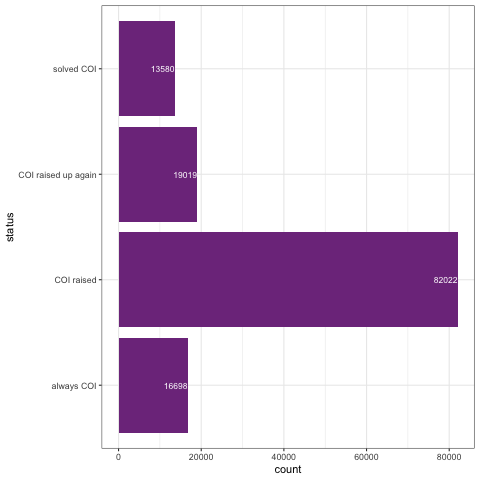

In [19]:
%%R -i coi_status

coi_status_plt <- ggplot(coi_status, aes(y=status, x=count, label=count)) + geom_bar(stat='identity', fill='#7F388B')+
geom_text(size = 3, hjust = 1, size = 12,color='white', position = position_dodge(width = 1), inherit.aes = TRUE) 
coi_status_plt